In [1]:
import PostProcessing as PP
import numpy as np
from CollisionApprox import Collision_approx as ca
from nu_e_coll import nu_e_collisions as ve
import matplotlib.pyplot as plt

#folder = "../../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew".format(300,1.28e-5,300,1.28e-5)
#data = np.load(folder + "/mass_{}_mix_{:.4}.npz".format(300,1.28e-5), allow_pickle=True)
#a_tot = data['scalefactors']
#T_tot = data['temp']
#e_tot = data['e']
#f_tot = data['fe']

N effective is 1.34
The dilution factor is 4.27


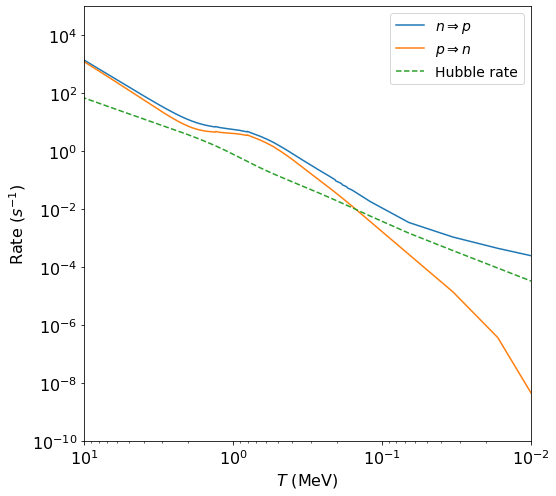

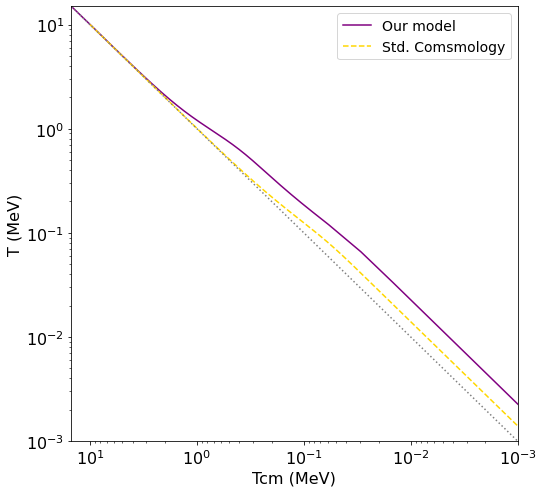

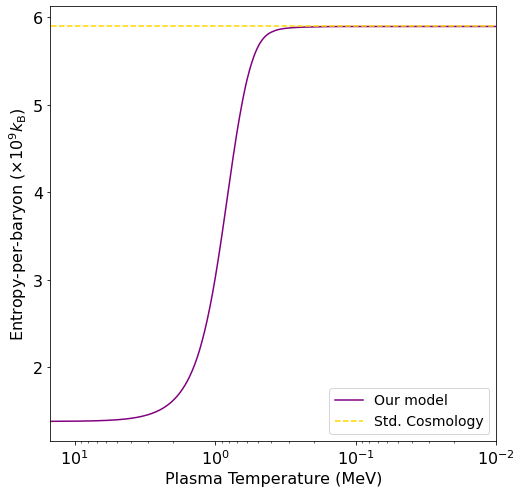

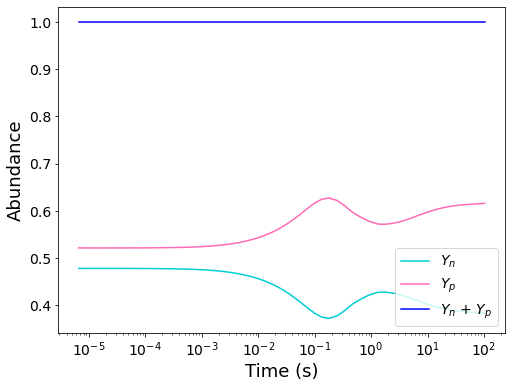

In [2]:
PP.pp(300,1.28e-5)

N effective is 2.99
The dilution factor is 1.62


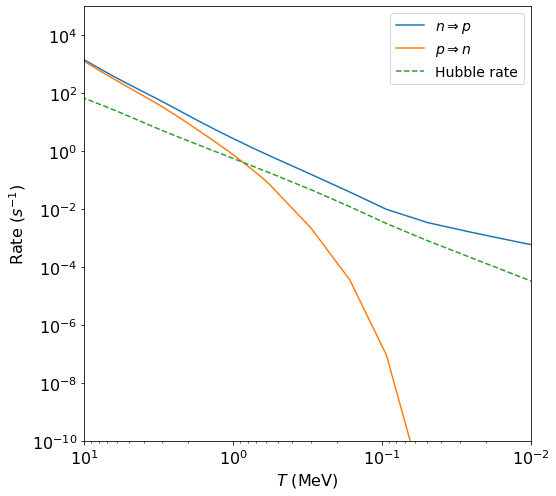

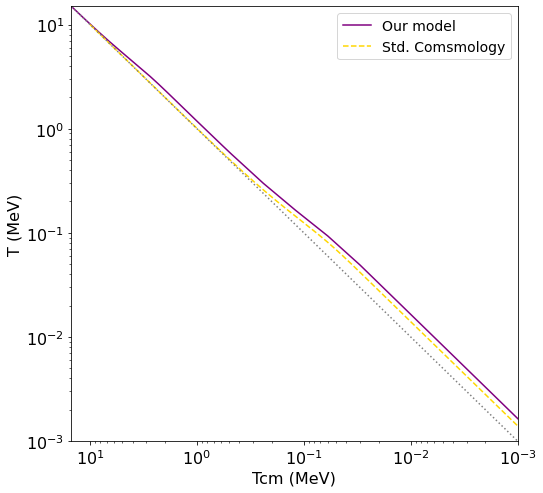

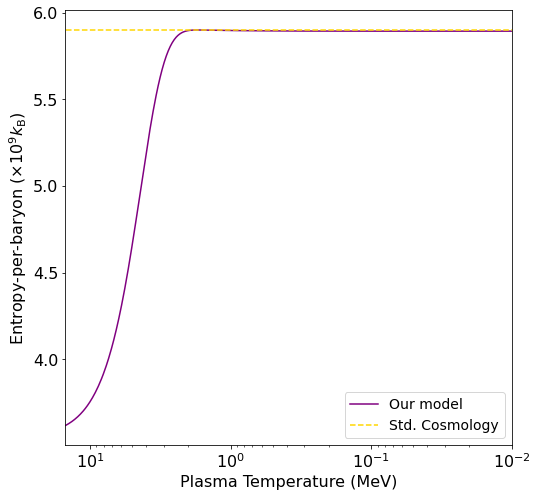

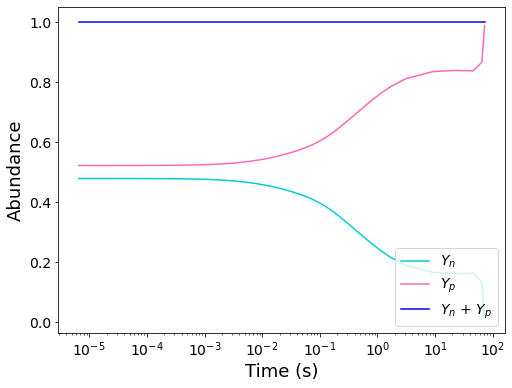

In [3]:
PP.pp(300,7e-5)

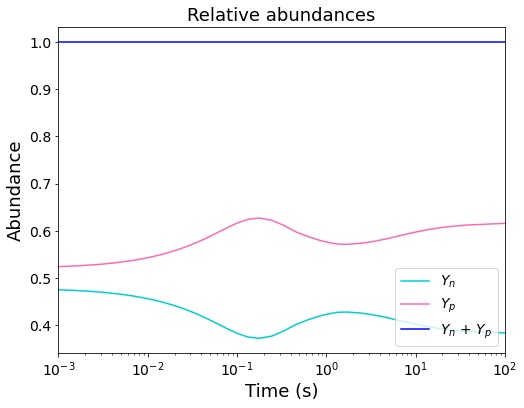

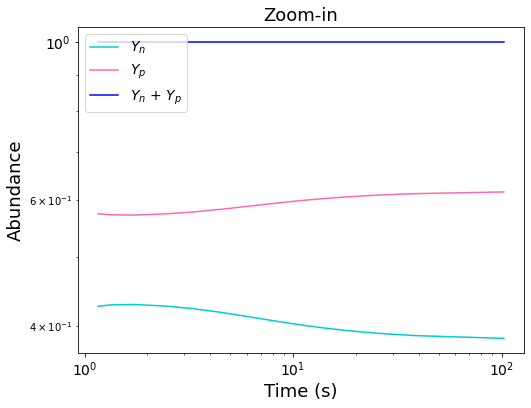

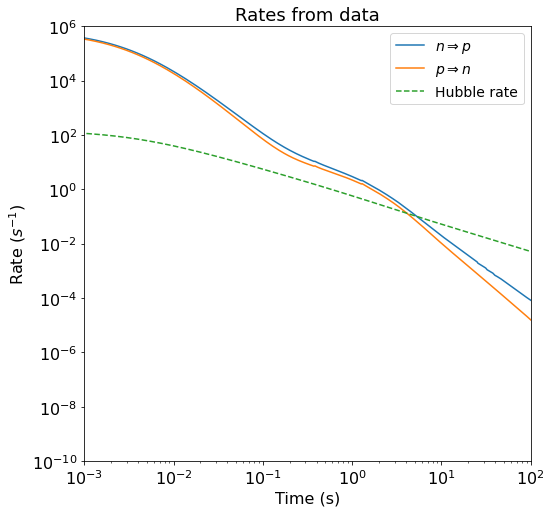

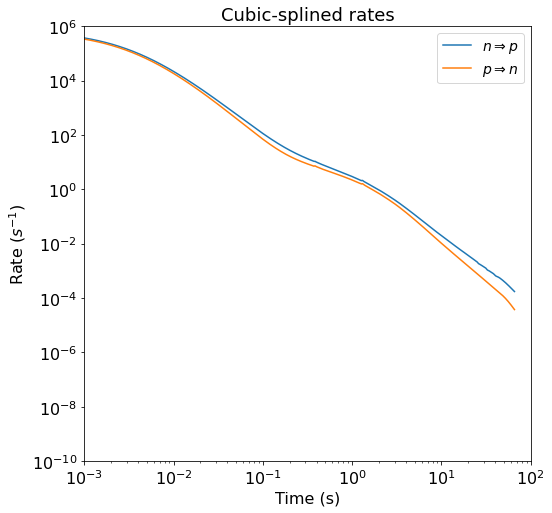

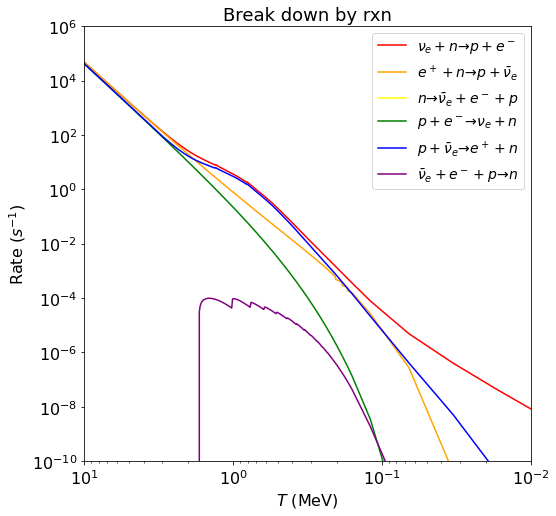

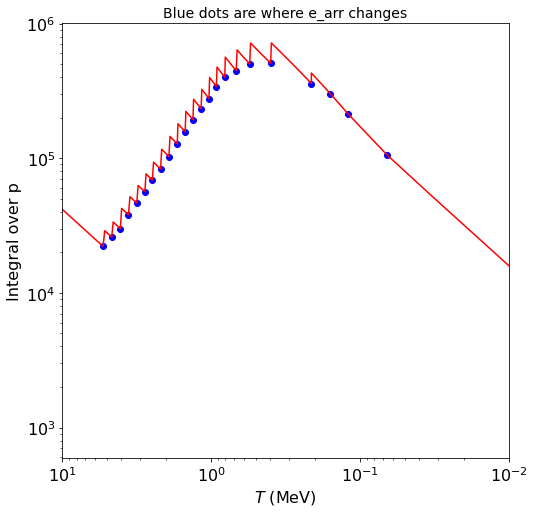

In [4]:
PP.inspect_graphs(300,1.28e-5)

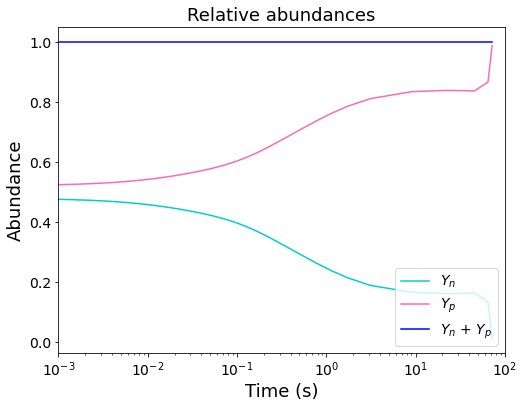

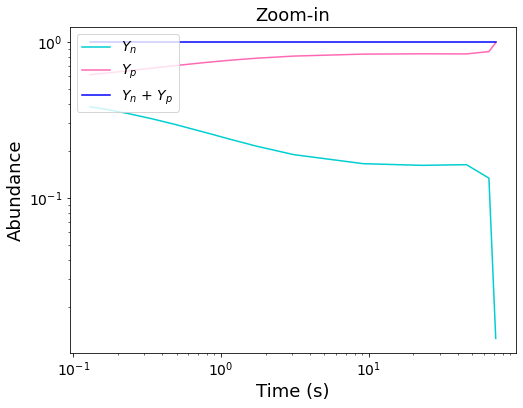

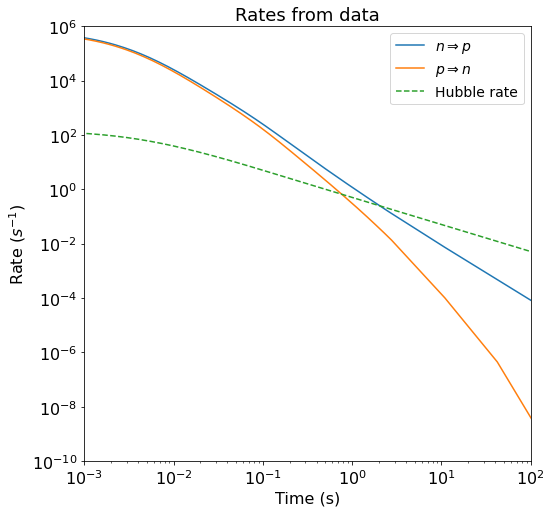

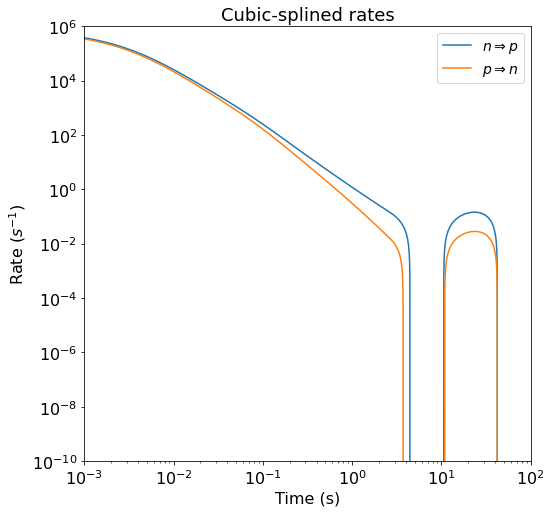

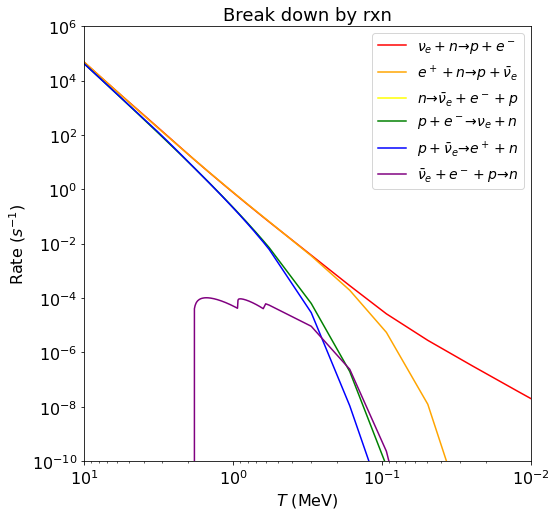

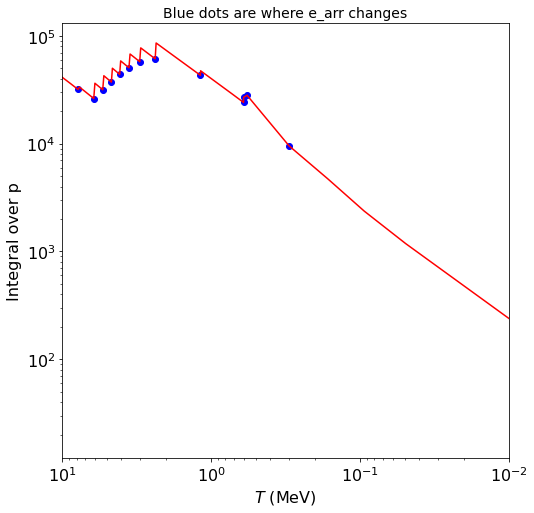

In [5]:
PP.inspect_graphs(300,7e-5)

/Users/hannahrasmussen/Work/Most_recent_code/PostProcessing/PostProcessing/PostProcessing.py:326: RuntimeWarning: overflow encountered in exp
  e_thermal = eps**3 / (np.exp(eps / a /  eq_Tcm[-1]) +1) / (2 * np.pi**3)


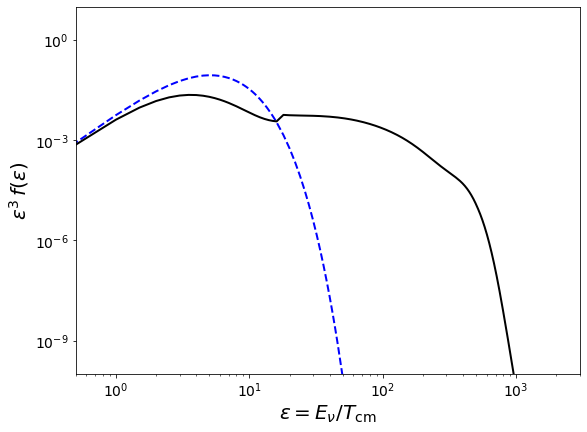

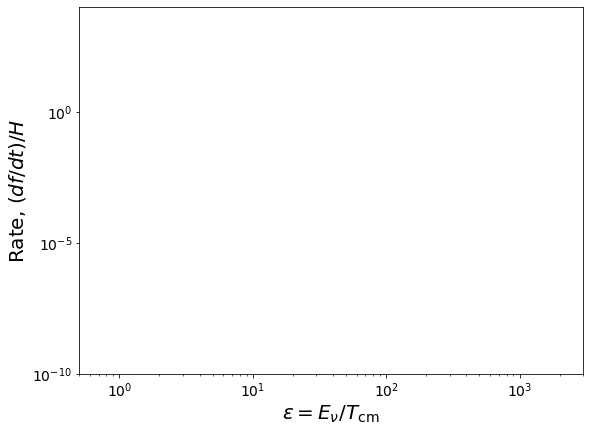

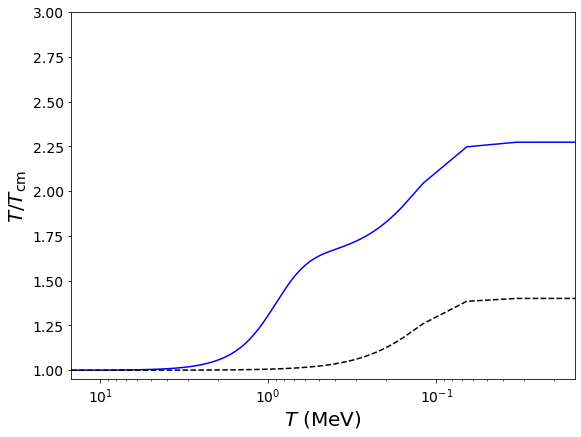

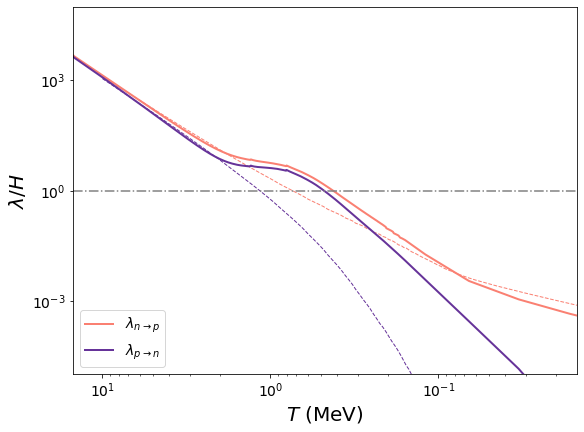

In [6]:
PP.make_graphs(300,1.28e-5)

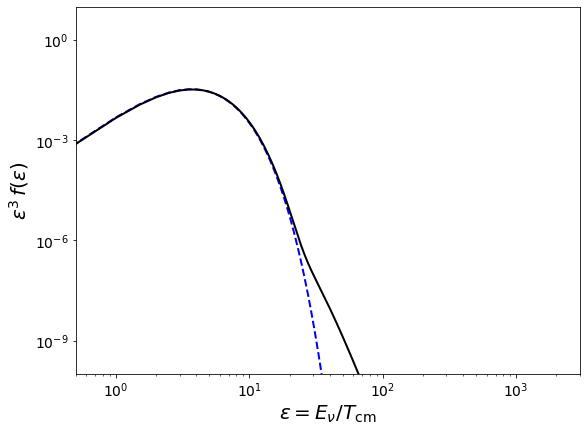

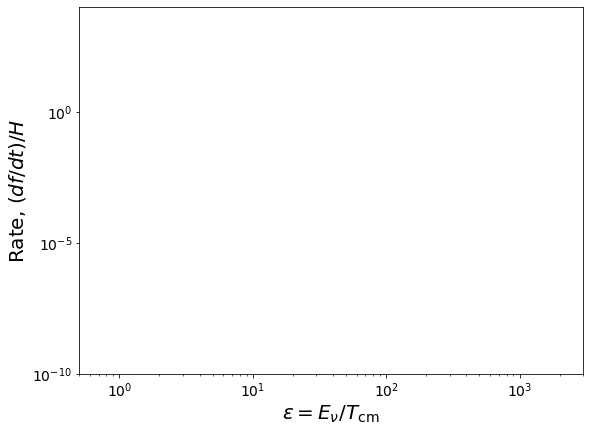

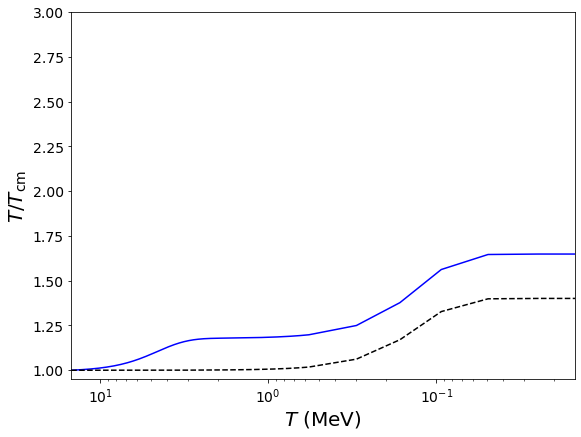

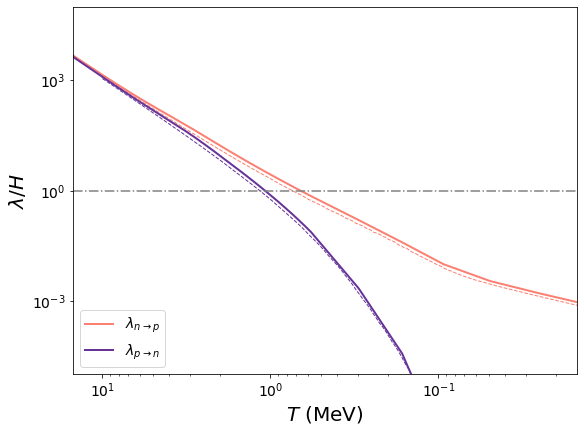

In [7]:
PP.make_graphs(300,7e-5)

/Users/hannahrasmussen/Work/Most_recent_code/PostProcessing/PostProcessing/PostProcessing.py:485: RuntimeWarning: overflow encountered in exp
  e_thermal.set_data(eps, eps**3 / (np.exp(eps / a /  eq_Tcm[i]) +1) / (2 * np.pi**3))


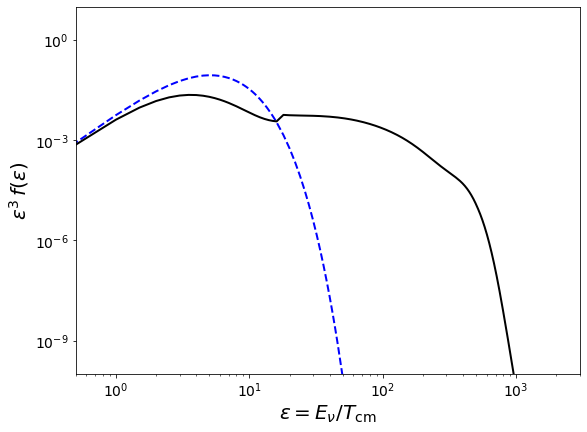

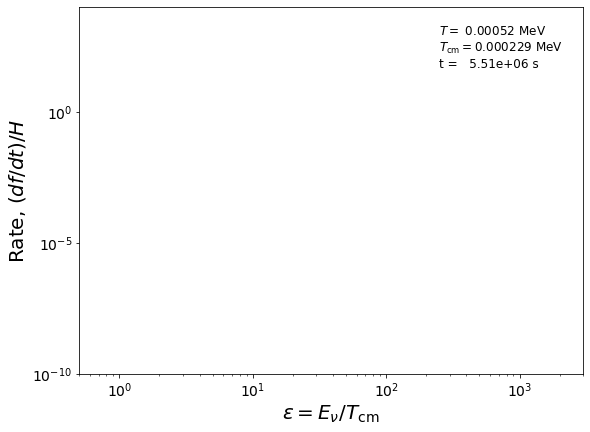

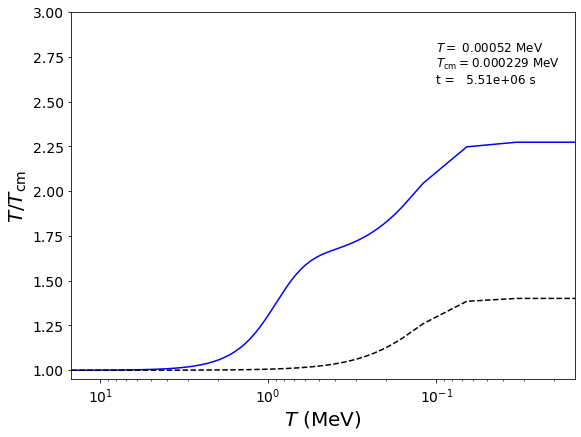

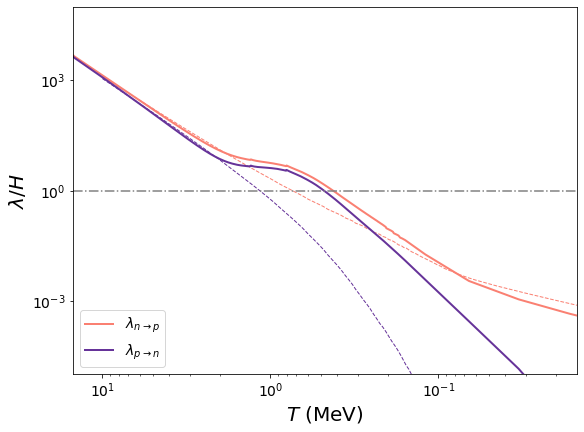

In [8]:
PP.make_movies(300,1.28e-5)

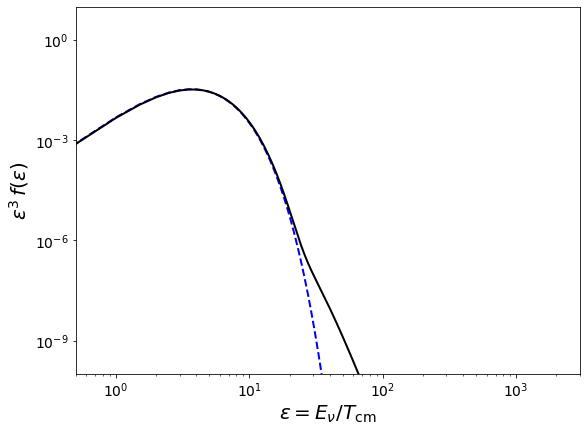

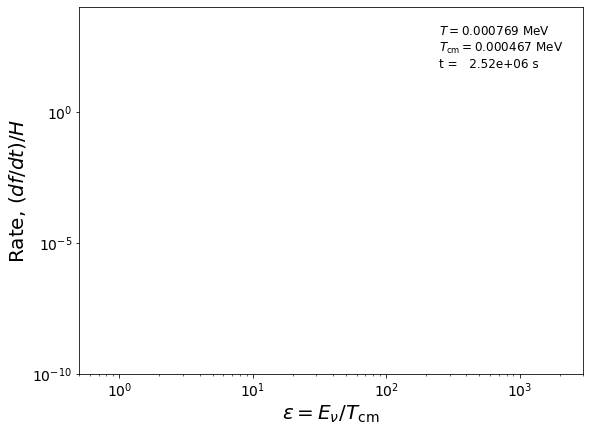

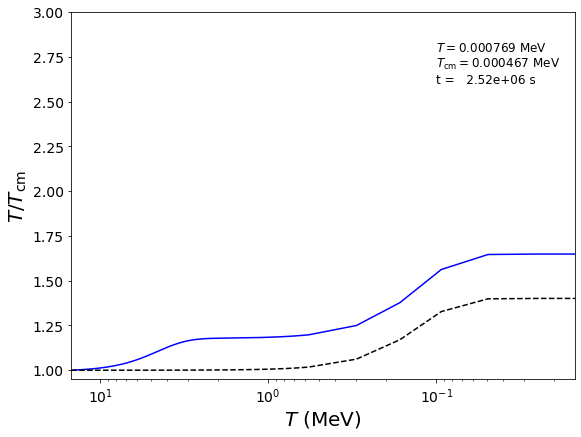

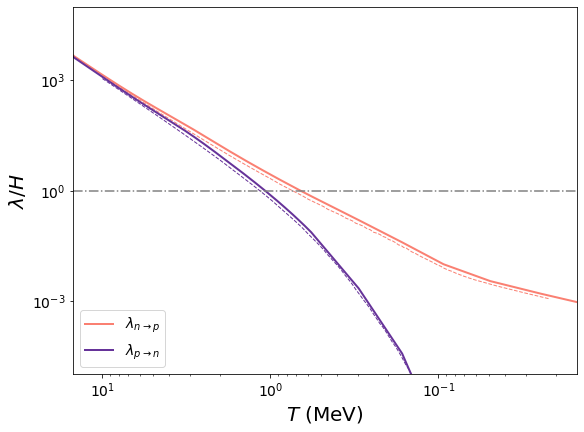

In [9]:
PP.make_movies(300,7e-5)

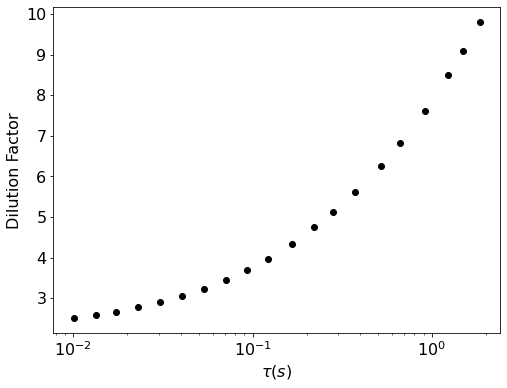

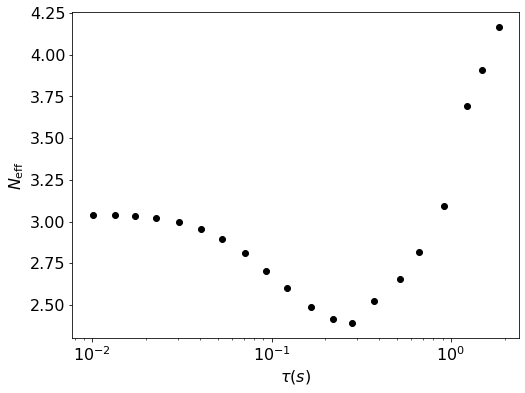

In [10]:
dilresults = np.load("/Users/hannahrasmussen/Work/Most_recent_code/300data/300data/300data_final.npz")
lifetime_array = dilresults['lifetime']
dil_array = dilresults['Dilution_Factor']
N_eff_array = dilresults['N_eff']

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,dil_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("Dilution Factor",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("dilution.pdf")

plt.figure(figsize=(8,6))
plt.semilogx(lifetime_array,N_eff_array,'o',color='k')
plt.xlabel("$\\tau(s)$",fontsize=16)
plt.ylabel("$N_{\\rm eff}$",fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.savefig("neff.pdf")